In [29]:
import albumentations as A
import os
from tqdm import tqdm
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import to_categorical

In [8]:
DATASET_DIR = os.path.join("..", "HandGesture", "images")
LABELS = os.listdir(DATASET_DIR)
IMAGE_SIZE = (195, 195)

In [24]:
IMAGES = []
for label in LABELS:
    label_dir = os.path.join(DATASET_DIR, label)
    for img in tqdm(os.listdir(label_dir), desc=f"images for '{label}' --->"):
        img_np = cv2.imread(os.path.join(label_dir, img), cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.
        img_np = cv2.resize(img_np, IMAGE_SIZE)
        IMAGES.append({
            "img": img_np,
            "label": label,
            "label_num": LABELS.index(label)
            })


images for 'up' --->: 100%|██████████| 504/504 [00:03<00:00, 150.48it/s]


In [27]:
random.shuffle(IMAGES)

In [53]:
X_IMAGES, y_IMAGES = train_test_split(IMAGES, test_size=0.2, random_state=42)

In [58]:
X_train = []
y_train = []
for img in X_IMAGES:
    X_train.append(img["img"])
    y_train.append(img["label_num"])

X_test = []
y_test = []
for img in y_IMAGES:
    X_test.append(img["img"])
    y_test.append(img["label_num"])

In [59]:
X_train = np.array(X_train).reshape(-1, *IMAGE_SIZE)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, *IMAGE_SIZE)
y_test = np.array(y_test)
y_train_encoded = to_categorical(y_train, num_classes=len(LABELS))
y_test_encoded = to_categorical(y_test, num_classes=len(LABELS))

In [64]:
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)

(4194, 195, 195)
(4194,)
(4194, 10)
(1049, 195, 195)
(1049,)
(1049, 10)


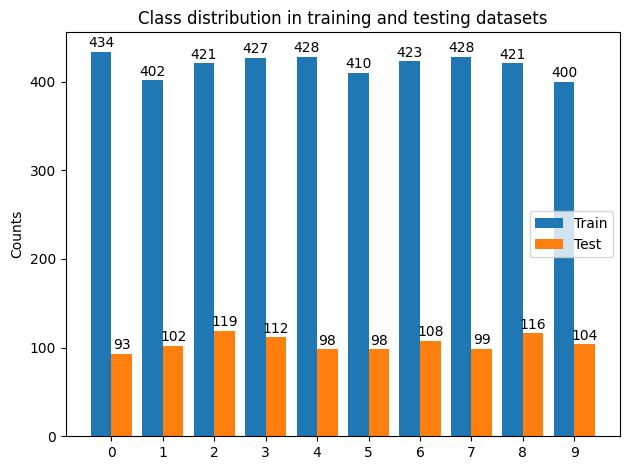

In [65]:
from collections import Counter


def visualize_class_distribution(y_train, y_test):
    """
    Visualizes the class distribution in training and testing datasets when the labels are provided as lists.
    Adds a numeric label at the top of each bar showing the count.

    Parameters:
    - y_train: List of training labels.
    - y_test: List of testing labels.
    """
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    all_labels = list(set(train_counter.keys()).union(set(test_counter.keys())))
    all_labels.sort()  # Sort the labels for consistent plotting
    train_counts = [train_counter[label] for label in all_labels]
    test_counts = [test_counter[label] for label in all_labels]

    x = range(len(all_labels))  # Label locations

    fig, ax = plt.subplots()
    train_bars = ax.bar([i - 0.2 for i in x], train_counts, width=0.4, label='Train', align='center')
    test_bars = ax.bar([i + 0.2 for i in x], test_counts, width=0.4, label='Test', align='center')

    ax.set_ylabel('Counts')
    ax.set_title('Class distribution in training and testing datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation='horizontal')
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(train_bars)
    autolabel(test_bars)

    plt.tight_layout()
    plt.show()

visualize_class_distribution(y_train, y_test)

In [67]:
model = Sequential(
    [
        Conv2D(32, (4, 4), activation="relu", input_shape=(*IMAGE_SIZE, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(len(LABELS), activation="softmax")
    ]
)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 192, 192, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,054,218 (30.72 MB)

 Trainable params: 8,054,218 (30.72 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.fit(X_train, y_train_encoded, epochs=3, validation_data=(X_test[:60], y_test_encoded[:60]))

Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 441ms/step - accuracy: 0.3596 - loss: 1.7342 - precision: 0.5979 - recall: 0.1908 - val_accuracy: 0.8167 - val_loss: 0.5645 - val_precision: 0.9216 - val_recall: 0.7833
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 58s 439ms/step - accuracy: 0.8968 - loss: 0.3194 - precision: 0.9271 - recall: 0.8744 - val_accuracy: 0.8667 - val_loss: 0.5515 - val_precision: 0.8966 - val_recall: 0.8667
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 429ms/step - accuracy: 0.9626 - loss: 0.1233 - precision: 0.9686 - recall: 0.9563 - val_accuracy: 0.8667 - val_loss: 0.3668 - val_precision: 0.9286 - val_recall: 0.8667


In [69]:
prediction = model.predict(X_test)
pred = np.argmax(prediction, axis=1)
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, pred)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step
Accuracy: 0.9132507149666349
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        93
           1       0.97      0.85      0.91       102
           2       0.89      0.99      0.94       119
           3       0.93      0.83      0.88       112
           4       0.91      0.80      0.85        98
           5       0.80      1.00      0.89        98
           6       0.98      0.98      0.98       108
           7       0.88      0.82      0.85        99
           8       0.93      0.95      0.94       116
           9       0.96      0.93      0.95       104

    accuracy                           0.91      1049
   macro avg       0.92      0.91      0.91      1049
weighted avg       0.92      0.91      0.91      1049

